In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import re
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report
)

# <div style="border-radius:10px; border:#D07220 solid; padding: 12px; background-color: #Q07220; font-size:100%; font-family:Comic Sans MS; font-family:Comic Sans MS; text-align:center"> STEP 1: Load Dataset & normalize columns </div>

In [2]:
# ===== Config =====
XLSX_PATH = Path(r"D:\Du lieu\Tài Liệu Đại Học\Trí Tuệ Nhân Tạo\AI FINAL GR2\FINAL (Code + Data)\Data\KFC HN Customer Feedback .xlsx")
assert XLSX_PATH.exists(), f"Không tìm thấy file: {XLSX_PATH}"

CLEAN_CSV = Path("kfc_clean.csv")
MODEL_PKL = Path("kfc_absa_aspects.pkl")
LABEL_PNG = Path("label_distribution.png")
ASPECT_PNG = Path("aspect_distribution.png")

# Mapping label
LABEL_MAP = {0: "None", 1: "Positive", 2: "Negative", 3: "Neutral"}
LABEL_MAP_VI = {
    0: "Không nhắc đến",
    1: "Tích cực",
    2: "Tiêu cực",
    3: "Trung tính",
}

In [3]:
print("=== Step 1: Load Excel & normalize columns ===")

xl = pd.ExcelFile(XLSX_PATH)
sheet_name = xl.sheet_names[0]
df_raw = xl.parse(sheet_name)

def normalize_col(c):
    return re.sub(r"\s+", "_", str(c).strip().lower())

df_raw.columns = [normalize_col(c) for c in df_raw.columns]
print("Sheet:", sheet_name)
print("Columns:", list(df_raw.columns))
df_raw.info

=== Step 1: Load Excel & normalize columns ===
Sheet: Sheet1
Columns: ['store_name', 'address', 'location', 'latitude', 'longitude', 'user_name', 'review_time', 'review_text', 'rating', 'source', 'language', 'translated_text', 'food_quality', 'food_price', 'price_discount', 'service_quality', 'service_order', 'restaurant_space', 'customer_experience']


<bound method DataFrame.info of                     store_name  \
0                KFC The Manor   
1                KFC The Manor   
2                KFC The Manor   
3                  KFC Văn Khê   
4                  KFC Đống Đa   
...                        ...   
11431          KFC Trần Thủ Hộ   
11432              KFC Đống Đa   
11433              KFC Láng Hạ   
11434  KFC TTTM Hồ Gương Plaza   
11435            KFC The Manor   

                                                 address  \
0      Tòa Nhà The Manor, Khu Dân Cư Mỹ Đình, Xã, 100...   
1      Tòa Nhà The Manor, Khu Dân Cư Mỹ Đình, Xã, 100...   
2      Tòa Nhà The Manor, Khu Dân Cư Mỹ Đình, Xã, 100...   
3      tòa CT5A thuộc dự án, Văn Khê tại, Khu đô thị ...   
4      Tòa nhà Kinh Đô, 292 P. Tây Sơn, Trung Liệt, Đ...   
...                                                  ...   
11431       South Building, Tứ Hiệp, Hanoi City, Vietnam   
11432  Tòa nhà Kinh Đô, 292 P. Tây Sơn, Trung Liệt, Đ...   
11433  175 P. Láng 

In [4]:
dist = df_raw["store_name"].astype(str).str.strip().value_counts()

print(dist)
print("\nNumber of stores:", dist.shape[0])
print("Total rows:", dist.sum())

store_name
KFC The Manor              3406
KFC Thanh Xuân Bắc         1324
KFC Đống Đa                1163
KFC Vincom                  917
KFC TTTM Hồ Gương Plaza     914
KFC Văn Khê                 867
KFC Láng Hạ                 805
KFC Trần Thủ Hộ             781
KFC Trần Duy Hưng           528
KFC Lê Thanh Nghị           329
KFC Royal City              163
KFC Phạm Ngọc Thạch         145
KFC Bạch Mai                 43
KFC Quang Trung              36
KFC TTTM Mê Linh             15
Name: count, dtype: int64

Number of stores: 15
Total rows: 11436


# <div style="border-radius:10px; border:#D07220 solid; padding: 12px; background-color: #Q07220; font-size:100%; font-family:Comic Sans MS; font-family:Comic Sans MS; text-align:center"> STEP 2: Pick text columns & detect aspects </div>

In [5]:
print("\n=== Step 2: Pick text columns & detect aspects ===")

TEXT_EN = "translated_text" if "translated_text" in df_raw.columns else (
          "review_text" if "review_text" in df_raw.columns else None)

TEXT_VI = "review_text" if "review_text" in df_raw.columns else None

if TEXT_EN is None and TEXT_VI is None:
    raise ValueError("No text column found (translated_text / review_text).")  

def is_aspect_col(s: pd.Series) -> bool:
    vals = pd.to_numeric(s, errors="coerce").dropna().astype(int).unique().tolist()
    return (len(vals) > 0) and set(vals).issubset({0, 1, 2, 3})

aspect_cols = [c for c in df_raw.columns if is_aspect_col(df_raw[c])]
if not aspect_cols:
    raise ValueError("No aspect column found with values in {0,1,2,3}")

print("Aspect columns:", aspect_cols)

df = df_raw.copy()

if TEXT_EN:
    df["text_en"] = df_raw[TEXT_EN].astype(str).str.strip()
if TEXT_VI:
    df["text_vi"] = df_raw[TEXT_VI].astype(str).str.strip()
else:
    df["text_vi"] = ""

base_text_col = "text_en" if "text_en" in df.columns else "text_vi"

df = df[df[base_text_col].str.len() > 0].reset_index(drop=True)
print("Shape after filtering empty text:", df.shape)



=== Step 2: Pick text columns & detect aspects ===
Aspect columns: ['food_quality', 'food_price', 'price_discount', 'service_quality', 'service_order', 'restaurant_space', 'customer_experience']
Shape after filtering empty text: (11436, 21)


# <div style="border-radius:10px; border:#D07220 solid; padding: 12px; background-color: #Q07220; font-size:100%; font-family:Comic Sans MS; font-family:Comic Sans MS; text-align:center"> STEP 3: Create overall label from aspects </div>

In [6]:
print("\n=== Step 3: Create overall label from aspects ===")

def overall_rule(row) -> int:
    pos = neg = neu = 0
    for c in aspect_cols:
        v = pd.to_numeric(row.get(c, 0), errors="coerce")
        v = int(v) if pd.notna(v) else 0
        if v == 1: pos += 1
        elif v == 2: neg += 1
        elif v == 3: neu += 1
    if pos > neg: return 1
    if neg > pos: return 2
    if (pos + neg + neu) > 0: return 3
    return 0

df["label_id"] = df.apply(overall_rule, axis=1).astype("Int64")
df["label_name"] = df["label_id"].map(LABEL_MAP)
df["label_name_vi"] = df["label_id"].map(LABEL_MAP_VI)



=== Step 3: Create overall label from aspects ===


# <div style="border-radius:10px; border:#D07220 solid; padding: 12px; background-color: #Q07220; font-size:100%; font-family:Comic Sans MS; font-family:Comic Sans MS; text-align:center"> Step 4: EDA </div>


=== Step 4: EDA ===
Saved aspect distribution to: aspect_distribution.png


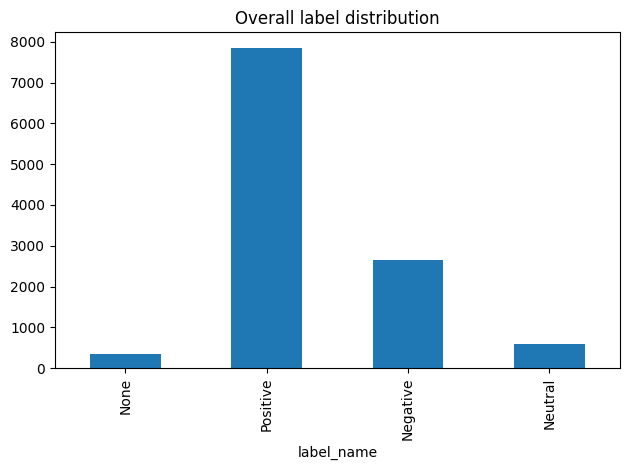

<Figure size 640x480 with 0 Axes>

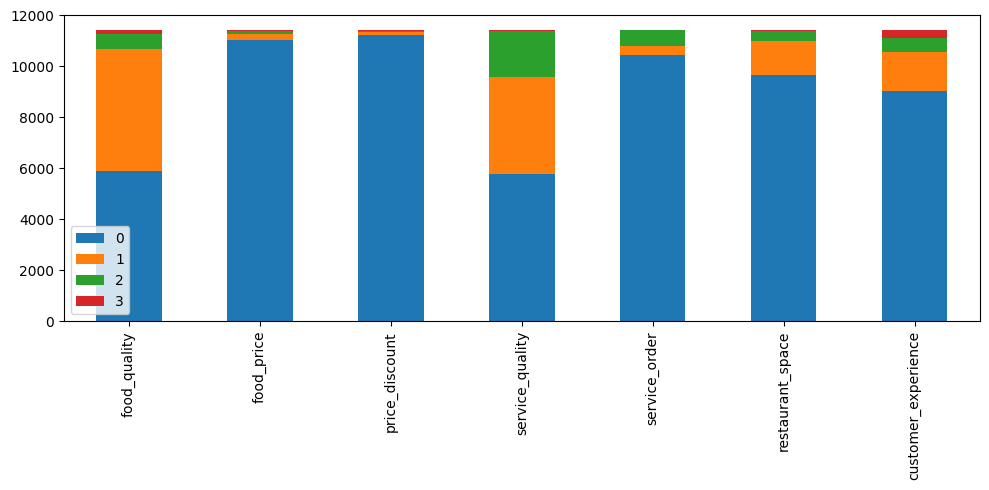

In [7]:
print("\n=== Step 4: EDA ===")

order_names = ["None", "Positive", "Negative", "Neutral"]

label_counts = df["label_name"].value_counts().reindex(order_names).fillna(0).astype(int)

plt.figure()
label_counts.plot(kind="bar")
plt.title("Overall label distribution")
plt.tight_layout()
plt.savefig(LABEL_PNG)

aspect_dist = {}
for c in aspect_cols:
    vc = (
        pd.to_numeric(df[c], errors="coerce")
        .dropna()
        .astype(int)
        .value_counts()
        .reindex([0,1,2,3])
        .fillna(0)
        .astype(int)
    )
    aspect_dist[c] = vc

aspect_df = pd.DataFrame(aspect_dist).T
plt.figure()
aspect_df.plot(kind="bar", stacked=True, figsize=(10,5))
plt.tight_layout()
plt.savefig(ASPECT_PNG)

print("Saved aspect distribution to:", ASPECT_PNG)

# <div style="border-radius:10px; border:#D07220 solid; padding: 12px; background-color: #Q07220; font-size:100%; font-family:Comic Sans MS; font-family:Comic Sans MS; text-align:center"> STEP 5: Train per-aspect models (3 models) </div>

In [8]:
# print("\n=== Step 5: Train per-aspect models (3 models) ===")

# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import MultinomialNB

# text_col = base_text_col
# pipelines_best = {}   # model tốt nhất mỗi aspect
# pipelines_svm = {}    # >>> ADDED
# pipelines_lr = {}     # >>> ADDED
# pipelines_nb = {}     # >>> ADDED

# comparison_rows = []

# for aspect in aspect_cols:
#     sub = df[[text_col, aspect]].dropna().copy()
#     X = sub[text_col].astype(str)
#     y = (
#         pd.to_numeric(sub[aspect], errors="coerce")
#         .fillna(0)
#         .astype(int)
#         .clip(0, 3)
#     )

#     uniq = np.unique(y)
#     if len(sub) < 30 or len(uniq) < 2:
#         print(f"⚠️ Skip {aspect}: n={len(sub)}, classes={uniq}")
#         continue

#     vc = pd.Series(y).value_counts()
#     strat = y if vc.min() >= 2 else None

#     Xtr, Xte, ytr, yte = train_test_split(
#         X, y, test_size=0.2, random_state=42, stratify=strat
#     )

#     # -------------------------------------------------
#     # Model 1 – Linear SVM
#     # -------------------------------------------------
#     pipe_svm = Pipeline([
#         ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2)),
#         ("svm", LinearSVC()),
#     ])
#     pipe_svm.fit(Xtr, ytr)
#     pred_svm = pipe_svm.predict(Xte)
#     acc_svm = accuracy_score(yte, pred_svm)

#     # -------------------------------------------------
#     # Model 2 – Logistic Regression
#     # -------------------------------------------------
#     pipe_lr = Pipeline([
#         ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2)),
#         ("lr", LogisticRegression(max_iter=1000)),
#     ])
#     pipe_lr.fit(Xtr, ytr)
#     pred_lr = pipe_lr.predict(Xte)
#     acc_lr = accuracy_score(yte, pred_lr)

#     # -------------------------------------------------
#     # Model 3 – Naive Bayes
#     # -------------------------------------------------
#     pipe_nb = Pipeline([
#         ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2)),
#         ("nb", MultinomialNB()),
#     ])
#     pipe_nb.fit(Xtr, ytr)
#     pred_nb = pipe_nb.predict(Xte)
#     acc_nb = accuracy_score(yte, pred_nb)

#     # -------------------------------------------------
#     # Choose best model to use - best.pkl
#     # -------------------------------------------------
#     best_name, best_acc, best_pipe = max(
#         [
#             ("svm", acc_svm, pipe_svm),
#             ("lr", acc_lr, pipe_lr),
#             ("nb", acc_nb, pipe_nb),
#         ],
#         key=lambda x: x[1]
#     )

#     print(f"\n### {aspect}")
#     print(f"[SVM] {acc_svm:.4f} | [LR] {acc_lr:.4f} | [NB] {acc_nb:.4f}")
#     print(f"→ Best model: {best_name} (acc={best_acc:.4f})")

#     # Save to dict
#     pipelines_best[aspect] = best_pipe
#     pipelines_svm[aspect] = pipe_svm     # >>> ADDED
#     pipelines_lr[aspect] = pipe_lr       # >>> ADDED
#     pipelines_nb[aspect] = pipe_nb       # >>> ADDED

#     comparison_rows.append({
#         "aspect": aspect,
#         "svm_acc": acc_svm,
#         "lr_acc": acc_lr,
#         "nb_acc": acc_nb,
#         "best_model": best_name,
#         "best_acc": best_acc,
#     })

# # ==============================
# # SAVE 4 FILE MODEL (BEST + SVM + LR + NB)
# # ==============================

# joblib.dump({
#     "pipelines": pipelines_best,
#     "label_map": LABEL_MAP,
#     "aspects": list(pipelines_best.keys()),
#     "text_col": text_col,
# }, "kfc_absa_aspects.pkl")
# print("Saved BEST model → kfc_absa_aspects.pkl")

# joblib.dump({
#     "pipelines": pipelines_svm,
#     "label_map": LABEL_MAP,
#     "aspects": list(pipelines_svm.keys()),
#     "text_col": text_col,
# }, "kfc_absa_aspects_svm.pkl")
# print("Saved SVM model → kfc_absa_aspects_svm.pkl")

# joblib.dump({
#     "pipelines": pipelines_lr,
#     "label_map": LABEL_MAP,
#     "aspects": list(pipelines_lr.keys()),
#     "text_col": text_col,
# }, "kfc_absa_aspects_lr.pkl")
# print("Saved LR model → kfc_absa_aspects_lr.pkl")

# joblib.dump({
#     "pipelines": pipelines_nb,
#     "label_map": LABEL_MAP,
#     "aspects": list(pipelines_nb.keys()),
#     "text_col": text_col,
# }, "kfc_absa_aspects_nb.pkl")
# print("Saved NB model → kfc_absa_aspects_nb.pkl")

# print("\n🎉 DONE — All 4 model files saved!")


In [ ]:
print("\n=== Step 5: Train per-aspect models (3 models) ===")

text_col = base_text_col
pipelines_best = {}   # best model per aspect (selected by score below)
pipelines_svm = {}
pipelines_lr = {}
pipelines_nb = {}

comparison_rows = []

# ============================================
# Helper: compute metrics (Accuracy + P/R/F1)
# ============================================
def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)

    # Macro: treat all classes equally (good when imbalance exists)
    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )

    # Weighted: weight by support (overall performance by class frequency)
    p_w, r_w, f1_w, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted", zero_division=0
    )

    return {
        "acc": acc,
        "precision_macro": p_macro,
        "recall_macro": r_macro,
        "f1_macro": f1_macro,
        "precision_weighted": p_w,
        "recall_weighted": r_w,
        "f1_weighted": f1_w,
    }

# ============================================
# IMPORTANT: choose best model by key metrics
# Recommended: prioritize F1(macro) because of class imbalance.
# Tiebreakers: F1(weighted) then Accuracy.
# ============================================
def pick_best_model(candidates):
    """
    candidates: list of tuples (name, metrics_dict, pipeline)
    Select best by:
      1) highest f1_macro
      2) then highest f1_weighted
      3) then highest acc
    """
    best = max(
        candidates,
        key=lambda t: (t[1]["f1_macro"], t[1]["f1_weighted"], t[1]["acc"])
    )
    return best  # (best_name, best_metrics, best_pipe)

for aspect in aspect_cols:
    sub = df[[text_col, aspect]].dropna().copy()
    X = sub[text_col].astype(str)
    y = (
        pd.to_numeric(sub[aspect], errors="coerce")
        .fillna(0)
        .astype(int)
        .clip(0, 3)
    )

    uniq = np.unique(y)
    if len(sub) < 30 or len(uniq) < 2:
        print(f"⚠️ Skip {aspect}: n={len(sub)}, classes={uniq}")
        continue

    vc = pd.Series(y).value_counts()
    strat = y if vc.min() >= 2 else None

    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=strat
    )

    # -------------------------------------------------
    # Model 1 – Linear SVM
    # -------------------------------------------------
    pipe_svm = Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1, 2), min_df=2)),
        ("svm", LinearSVC()),
    ])
    pipe_svm.fit(Xtr, ytr)
    pred_svm = pipe_svm.predict(Xte)
    m_svm = compute_metrics(yte, pred_svm)

    # -------------------------------------------------
    # Model 2 – Logistic Regression
    # -------------------------------------------------
    pipe_lr = Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1, 2), min_df=2)),
        ("lr", LogisticRegression(max_iter=1000)),
    ])
    pipe_lr.fit(Xtr, ytr)
    pred_lr = pipe_lr.predict(Xte)
    m_lr = compute_metrics(yte, pred_lr)

    # -------------------------------------------------
    # Model 3 – Naive Bayes
    # -------------------------------------------------
    pipe_nb = Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1, 2), min_df=2)),
        ("nb", MultinomialNB()),
    ])
    pipe_nb.fit(Xtr, ytr)
    pred_nb = pipe_nb.predict(Xte)
    m_nb = compute_metrics(yte, pred_nb)

    # -------------------------------------------------
    # Choose best model by key metrics (F1-macro first)
    # -------------------------------------------------
    best_name, best_metrics, best_pipe = pick_best_model([
        ("svm", m_svm, pipe_svm),
        ("lr",  m_lr,  pipe_lr),
        ("nb",  m_nb,  pipe_nb),
    ])

    print(f"\n### {aspect}")
    print(
        f"[SVM] acc={m_svm['acc']:.4f} | P(macro)={m_svm['precision_macro']:.4f} | "
        f"R(macro)={m_svm['recall_macro']:.4f} | F1(macro)={m_svm['f1_macro']:.4f} | "
        f"F1(weighted)={m_svm['f1_weighted']:.4f}"
    )
    print(
        f"[LR ] acc={m_lr['acc']:.4f} | P(macro)={m_lr['precision_macro']:.4f} | "
        f"R(macro)={m_lr['recall_macro']:.4f} | F1(macro)={m_lr['f1_macro']:.4f} | "
        f"F1(weighted)={m_lr['f1_weighted']:.4f}"
    )
    print(
        f"[NB ] acc={m_nb['acc']:.4f} | P(macro)={m_nb['precision_macro']:.4f} | "
        f"R(macro)={m_nb['recall_macro']:.4f} | F1(macro)={m_nb['f1_macro']:.4f} | "
        f"F1(weighted)={m_nb['f1_weighted']:.4f}"
    )

    print(
        f"→ Best model: {best_name} "
        f"(F1_macro={best_metrics['f1_macro']:.4f}, "
        f"F1_weighted={best_metrics['f1_weighted']:.4f}, "
        f"acc={best_metrics['acc']:.4f})"
    )

    # Save to dict
    pipelines_best[aspect] = best_pipe
    pipelines_svm[aspect] = pipe_svm
    pipelines_lr[aspect] = pipe_lr
    pipelines_nb[aspect] = pipe_nb

    # Store all metrics to comparison_rows (Accuracy + Precision/Recall/F1)
    comparison_rows.append({
        "aspect": aspect,

        "svm_acc": m_svm["acc"],
        "svm_precision_macro": m_svm["precision_macro"],
        "svm_recall_macro": m_svm["recall_macro"],
        "svm_f1_macro": m_svm["f1_macro"],
        "svm_f1_weighted": m_svm["f1_weighted"],

        "lr_acc": m_lr["acc"],
        "lr_precision_macro": m_lr["precision_macro"],
        "lr_recall_macro": m_lr["recall_macro"],
        "lr_f1_macro": m_lr["f1_macro"],
        "lr_f1_weighted": m_lr["f1_weighted"],

        "nb_acc": m_nb["acc"],
        "nb_precision_macro": m_nb["precision_macro"],
        "nb_recall_macro": m_nb["recall_macro"],
        "nb_f1_macro": m_nb["f1_macro"],
        "nb_f1_weighted": m_nb["f1_weighted"],

        "best_model": best_name,
        "best_f1_macro": best_metrics["f1_macro"],
        "best_f1_weighted": best_metrics["f1_weighted"],
        "best_acc": best_metrics["acc"],
    })

# ============================================
# SAVE METRICS TABLE (CSV)
# ============================================
df_metrics = pd.DataFrame(comparison_rows)

# Sort by best_f1_macro (descending) because we select best by that
if not df_metrics.empty:
    df_metrics = df_metrics.sort_values("best_f1_macro", ascending=False)

df_metrics.to_csv(r"D:\Du lieu\Tài Liệu Đại Học\Trí Tuệ Nhân Tạo\AI FINAL GR2\FINAL (Code + Data)\ABSA KFC HN\kfc_absa_metrics_by_aspect.csv", index=False, encoding="utf-8-sig")
print("\nSaved metrics table → kfc_absa_metrics_by_aspect.csv")

# ==============================
# SAVE 4 MODEL FILES (BEST + SVM + LR + NB)
# ==============================
joblib.dump({
    "pipelines": pipelines_best,
    "label_map": LABEL_MAP,
    "aspects": list(pipelines_best.keys()),
    "text_col": text_col,
}, "kfc_absa_aspects.pkl")
print("Saved BEST model → kfc_absa_aspects.pkl")

joblib.dump({
    "pipelines": pipelines_svm,
    "label_map": LABEL_MAP,
    "aspects": list(pipelines_svm.keys()),
    "text_col": text_col,
}, "kfc_absa_aspects_svm.pkl")
print("Saved SVM model → kfc_absa_aspects_svm.pkl")

joblib.dump({
    "pipelines": pipelines_lr,
    "label_map": LABEL_MAP,
    "aspects": list(pipelines_lr.keys()),
    "text_col": text_col,
}, "kfc_absa_aspects_lr.pkl")
print("Saved LR model → kfc_absa_aspects_lr.pkl")

joblib.dump({
    "pipelines": pipelines_nb,
    "label_map": LABEL_MAP,
    "aspects": list(pipelines_nb.keys()),
    "text_col": text_col,
}, "kfc_absa_aspects_nb.pkl")
print("Saved NB model → kfc_absa_aspects_nb.pkl")

print("\nDONE — All 4 model files saved!")



=== Step 5: Train per-aspect models (3 models) ===

### food_quality
[SVM] acc=0.9091 | P(macro)=0.7012 | R(macro)=0.6243 | F1(macro)=0.6403 | F1(weighted)=0.9029
[LR ] acc=0.9025 | P(macro)=0.6498 | R(macro)=0.5867 | F1(macro)=0.6086 | F1(weighted)=0.8930
[NB ] acc=0.8274 | P(macro)=0.4137 | R(macro)=0.4435 | F1(macro)=0.4281 | F1(weighted)=0.7989
→ Best model: svm (F1_macro=0.6403, F1_weighted=0.9029, acc=0.9091)

### food_price
[SVM] acc=0.9781 | P(macro)=0.6462 | R(macro)=0.5129 | F1(macro)=0.5612 | F1(weighted)=0.9750
[LR ] acc=0.9768 | P(macro)=0.7029 | R(macro)=0.4476 | F1(macro)=0.5210 | F1(weighted)=0.9715
[NB ] acc=0.9663 | P(macro)=0.2416 | R(macro)=0.2500 | F1(macro)=0.2457 | F1(weighted)=0.9498
→ Best model: svm (F1_macro=0.5612, F1_weighted=0.9750, acc=0.9781)

### price_discount
[SVM] acc=0.9812 | P(macro)=0.3586 | R(macro)=0.2828 | F1(macro)=0.2990 | F1(weighted)=0.9750
[LR ] acc=0.9825 | P(macro)=0.2456 | R(macro)=0.2500 | F1(macro)=0.2478 | F1(weighted)=0.9739
[NB ] 

In [10]:
# -----------------------------
# 1) Load metrics table
# -----------------------------
# If you already have df_metrics in memory, comment out the next line.
df_metrics = pd.read_csv(r"D:\Du lieu\Tài Liệu Đại Học\Trí Tuệ Nhân Tạo\AI FINAL GR2\FINAL (Code + Data)\ABSA KFC HN\kfc_absa_metrics_by_aspect.csv")

# -----------------------------
# 2) Convert wide -> long form
# -----------------------------
metrics = ["acc", "precision_macro", "recall_macro", "f1_macro", "f1_weighted"]
models = ["svm", "lr", "nb"]

rows = []
for _, r in df_metrics.iterrows():
    aspect_raw = str(r["aspect"])
    aspect_label = aspect_raw.replace("_", " ").title()

    for m in models:
        for met in metrics:
            col = f"{m}_{met}"
            if col in df_metrics.columns:
                rows.append({
                    "Aspect": aspect_label,
                    "Model": m.upper(),
                    "MetricKey": met,
                    "Value": float(r[col])
                })

df_long = pd.DataFrame(rows)

metric_name_map = {
    "acc": "Accuracy",
    "precision_macro": "Precision (Macro)",
    "recall_macro": "Recall (Macro)",
    "f1_macro": "F1-score (Macro)",
    "f1_weighted": "F1-score (Weighted)"
}
df_long["Metric"] = df_long["MetricKey"].map(metric_name_map).fillna(df_long["MetricKey"])

# Optional: set global style (no color specified; seaborn uses defaults)
sns.set_theme()

# -----------------------------
# 3) Helper function: grouped bar chart for ONE metric
# -----------------------------
def plot_metric(metric_name: str, figsize=(14, 6)):
    data = df_long[df_long["Metric"] == metric_name].copy()
    if data.empty:
        print(f"No data found for metric: {metric_name}")
        return

    plt.figure(figsize=figsize)
    ax = sns.barplot(
        data=data,
        x="Aspect",
        y="Value",
        hue="Model"
    )
    ax.set_title(f"Model Comparison by Aspect — {metric_name}", fontsize=14)
    ax.set_xlabel("Aspect")
    ax.set_ylabel(metric_name)
    ax.set_ylim(0, 1)
    plt.xticks(rotation=30, ha="right")
    plt.legend(title="Model")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 4) Plot single-metric charts (recommended)
# -----------------------------
plot_metric("F1-score (Macro)")
plot_metric("Accuracy")
plot_metric("Precision (Macro)")
plot_metric("Recall (Macro)")
plot_metric("F1-score (Weighted)")

# -----------------------------
# 5) Plot ALL metrics in one figure (facets)
# -----------------------------
g = sns.catplot(
    data=df_long,
    x="Aspect",
    y="Value",
    hue="Model",
    col="Metric",
    kind="bar",
    col_wrap=2,
    height=4,
    aspect=1.25,
    sharey=False
)

g.set_titles("{col_name}")
g.set_axis_labels("Aspect", "Score")

for ax in g.axes.flat:
    ax.set_ylim(0, 1)
    for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_ha("right")

plt.tight_layout()
plt.show()


NameError: name 'sns' is not defined

# <div style="border-radius:10px; border:#D07220 solid; padding: 12px; background-color: #Q07220; font-size:100%; font-family:Comic Sans MS; font-family:Comic Sans MS; text-align:center"> DEMO BY STREAMLIT </div>

In [ ]:
from pathlib import Path

APP_PY = Path("app.py")


In [ ]:
# ==== Step 8. Create Streamlit app (app.py) to demo the UI ====
app_code = '''\


# app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib
from pathlib import Path

st.set_page_config(page_title="KFC Aspect Sentiment (ABSA)", layout="wide")
st.title("🍗 KFC Aspect Sentiment — Demo")

# 0=None, 1=Positive, 2=Negative, 3=Neutral
DEFAULT_LABEL_MAP = {0: "None", 1: "Positive", 2: "Negative", 3: "Neutral"}

# ========================================================
# 🔥 NEW: Model Switching Options
# ========================================================
MODEL_OPTIONS = {
    "Best Model": "kfc_absa_aspects.pkl",
    "SVM Model": "kfc_absa_aspects_svm.pkl",
    "Logistic Regression": "kfc_absa_aspects_lr.pkl",
    "Naive Bayes": "kfc_absa_aspects_nb.pkl",
}

# ========================================================
# Load model based on selection
# ========================================================
@st.cache_resource
def load_models(model_path: str):
    p = Path(model_path)
    if not p.exists():
        raise FileNotFoundError(f"Model not found: {p.resolve()}")

    obj = joblib.load(p)
    pipelines = obj["pipelines"]
    aspects = obj.get("aspects", list(pipelines.keys()))
    label_map = obj.get("label_map", DEFAULT_LABEL_MAP)

    # Normalize label_map keys to int
    clean_map = {}
    for k, v in label_map.items():
        try:
            clean_map[int(k)] = str(v)
        except:
            pass
    for k, v in DEFAULT_LABEL_MAP.items():
        clean_map.setdefault(k, v)

    return pipelines, aspects, clean_map

# ========================================================
# 🔥 NEW: Choose model in the sidebar
# ========================================================
st.sidebar.header("⚙️ Choose Model")
selected_model_name = st.sidebar.selectbox("Model:", list(MODEL_OPTIONS.keys()))
selected_model_file = MODEL_OPTIONS[selected_model_name]

st.sidebar.write("📦 Using model file:")
st.sidebar.code(selected_model_file)

pipelines, aspects, label_map = load_models(selected_model_file)

# ======================
# Sidebar label explanation
# ======================
st.sidebar.header("Label explanation")
st.sidebar.write("0 = None (not mentioned), 1 = Positive, 2 = Negative, 3 = Neutral")

# ======================
# UI tabs
# ======================
tab1, tab2 = st.tabs(["🔍 Analyze Text", "ℹ️ Guide"])

with tab1:
    st.subheader("Comment")
    txt = st.text_area(
        "Enter a review (English).",
        height=150
    )

    if st.button("Analyze", use_container_width=True):
        if not txt.strip():
            st.warning("Please enter some content.")
        else:
            rows = []
            pos = neg = neu = 0

            for asp in aspects:
                pipe = pipelines.get(asp)
                if pipe is None:
                    continue

                pred_id = int(pipe.predict([txt])[0])
                pred_name = label_map.get(pred_id, "None")

                # 👉 Same as the previous version: auto-extract aspects
                # Only SHOW aspects whose sentiment is not "None"
                if pred_name != "None":
                    pretty_asp = asp.replace("_", " ").title()
                    rows.append((pretty_asp, pred_name))

                if pred_id == 1:
                    pos += 1
                elif pred_id == 2:
                    neg += 1
                elif pred_id == 3:
                    neu += 1

            if not rows:
                st.info("The model did not find any aspect with sentiment (all are 'None').")
            else:
                st.write("**Aspect results (auto-extracted):**")
                st.table(pd.DataFrame(rows, columns=["Aspect", "Sentiment"]))

            # Majority-vote overall (ignore None)
            total_votes = pos + neg + neu
            if total_votes == 0:
                overall = "None"
            else:
                if pos > neg:
                    overall = "Positive"
                elif neg > pos:
                    overall = "Negative"
                else:
                    overall = "Neutral"

            st.success(f"**Total / Overall:** {overall}")

with tab2:
    st.subheader("How to use")
    st.markdown(
        """
- Step 1: Run `kfc_preprocess_and_train.py` to generate:
    - `kfc_clean.csv`
    - `kfc_absa_aspects.pkl`
    - `kfc_absa_aspects_svm.pkl`
    - `kfc_absa_aspects_lr.pkl`
    - `kfc_absa_aspects_nb.pkl`
- Step 2: Run:
    ```bash
    streamlit run app.py
    ```
- Tab **Analyze Text**:
    - Paste one review into the text box.
    - The app will **run through each aspect** and only display aspects whose sentiment is not "None".
- You can **choose models** in the sidebar to compare results.
        """
    )

                
'''
APP_PY.write_text(app_code, encoding="utf-8")
print("Saved Streamlit app to:", APP_PY)
print("Run on your machine:  pip install streamlit scikit-learn joblib pandas ;  streamlit run app.py")


Saved Streamlit app to: app.py
Run on your machine:  pip install streamlit scikit-learn joblib pandas ;  streamlit run app.py


In [ ]:
from pathlib import Path

APP_MAP_PY = Path(r"D:\Du lieu\Tài Liệu Đại Học\Trí Tuệ Nhân Tạo\AI FINAL GR2\FINAL (Code + Data)\ABSA KFC HN\app_map.py")

# ==== Step 9. Create Streamlit app_map.py ====
app_code = r'''\
import streamlit as st
import pandas as pd
import joblib
import folium
from folium.plugins import MarkerCluster
from streamlit_folium import st_folium
from pathlib import Path
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer

# ============================================
# CONFIG
# ============================================
DEFAULT_LABEL_MAP = {0: "None", 1: "Positive", 2: "Negative", 3: "Neutral"}

st.set_page_config(page_title="KFC Hanoi — ABSA + Map", layout="wide")
st.title("🍗 KFC Hanoi — Aspect-Based Sentiment & Branch Map")

# ============================================
# HELPER FOR review_time_en (relative strings)
# ============================================
def build_time_order():
    """
    Map '1 ngày trước', '2 tuần trước', '3 tháng trước', ... -> số ngày tương ứng.
    Dùng để sort & filter theo kiểu: từ mốc được chọn cho tới hiện tại.
    """
    order = {}
    # 1–6 ngày
    for i in range(1, 7):
        order[f"{i} ngày trước"] = i
    # 1–4 tuần (~7 ngày/tuần)
    for i in range(1, 5):
        order[f"{i} tuần trước"] = i * 7
    # 1–6 tháng (~30 ngày/tháng)
    for i in range(1, 7):
        order[f"{i} tháng trước"] = i * 30
    return order

TIME_ORDER = build_time_order()

# ============================================
# LOAD MODEL
# ============================================
@st.cache_resource(show_spinner=False)
def load_models(p: str):
    pth = Path(p)
    if not pth.exists():
        raise FileNotFoundError(f"Model not found: {pth.resolve()}")

    obj = joblib.load(p)
    pipelines = obj["pipelines"]
    aspects = obj.get("aspects", list(pipelines.keys()))
    label_map = obj.get("label_map", DEFAULT_LABEL_MAP)

    clean_map = {int(k): str(v) for k, v in label_map.items() if str(k).isdigit()}
    for k, v in DEFAULT_LABEL_MAP.items():
        clean_map.setdefault(k, v)

    return pipelines, aspects, clean_map


# ========================
# SIDEBAR CONFIG
# ========================
st.sidebar.header("⚙️ Configuration")

excel_path = st.sidebar.text_input(
    "Excel file path",
    value=r"D:\Du lieu\Tài Liệu Đại Học\Trí Tuệ Nhân Tạo\AI FINAL GR2\FINAL (Code + Data)\Data\KFC HN Customer Feedback .xlsx"#Data=============================================================================
)

model_path = st.sidebar.text_input(
    "Model path",
    value="kfc_absa_aspects.pkl"
)

try:
    PIPELINES, ASPECTS, LABEL_MAP = load_models(model_path)
except Exception as e:
    st.error(f"❌ Failed to load model: {e}")
    st.stop()


# ============================================
# LOAD EXCEL
# ============================================
@st.cache_data(show_spinner=False)
def load_excel(fp: str) -> pd.DataFrame:
    df = pd.read_excel(fp)
    df.columns = [str(c).strip().lower() for c in df.columns]
    return df

try:
    df = load_excel(excel_path)
except Exception as e:
    st.error(f"❌ Excel read error: {e}")
    st.stop()


# ============================================
# VALIDATION
# ============================================
required_cols = ["address", "location"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    st.error(f"❌ Missing columns in Excel file: {missing}")
    st.stop()

def split_lat_long(val):
    try:
        lat, lon = map(float, str(val).split(","))
        return lat, lon
    except Exception:
        return None, None

df["latitude"], df["longitude"] = zip(*df["location"].apply(split_lat_long))
data_map = df.dropna(subset=["latitude", "longitude", "address"]).copy()

if data_map.empty:
    st.error("❌ No valid branch data found.")
    st.stop()


# ============================================
# SENTIMENT PREDICT
# ============================================
def predict_aspect(text, aspect_key):
    if aspect_key not in PIPELINES:
        return "None"
    pred = PIPELINES[aspect_key].predict([text])[0]
    try:
        pred = int(pred)
    except Exception:
        pass
    return LABEL_MAP.get(pred, "None")


# ============================================
# SUMMARY SENTIMENT
# ============================================
def summarize_branch(df_branch, aspects):
    text_col = (
        "translated_text" if "translated_text" in df_branch.columns else
        "review_text" if "review_text" in df_branch.columns else None
    )
    if not text_col:
        return pd.DataFrame()

    rows = []
    texts = df_branch[text_col].astype(str).tolist()

    for a in aspects:
        counter = {"Positive": 0, "Negative": 0, "Neutral": 0, "None": 0}
        for t in texts:
            s = predict_aspect(t, a)
            counter[s] += 1

        rows.append({
            "Aspect": a.replace("_", " ").title(),
            "Positive": counter["Positive"],
            "Negative": counter["Negative"],
            "Neutral": counter["Neutral"],
            "None": counter["None"],
            "Total": counter["Positive"] + counter["Negative"] + counter["Neutral"],
        })

    return pd.DataFrame(rows).set_index("Aspect").sort_values("Total", ascending=False)


# ============================================
# KEYWORD EXTRACTION
# ============================================
def extract_keywords(texts, top_k=20):
    if len(texts) == 0:
        return pd.DataFrame(columns=["keyword", "count"])

    stopwords = [
        "the","and","for","with","that","this","was","were","from","but","are","have",
        "has","had","will","would","can","could","i","you","we","they","he","she","it",
        "to","in","on","at","of","a","an","is","am","be"
    ]

    cv = CountVectorizer(stop_words=stopwords, max_features=30)
    mat = cv.fit_transform(texts)
    freq = mat.sum(axis=0)

    words = [(w, int(freq[0, i])) for w, i in cv.vocabulary_.items()]
    df_kw = pd.DataFrame(words, columns=["keyword", "count"])
    return df_kw.sort_values("count", ascending=False)


# ============================================
# UI — TWO TABS
# ============================================
tab1, tab2 = st.tabs(["🗺️ Branch Map", "🔍 Check One Sentence"])



# ==========================================================
# TAB 1 — MAP + FEEDBACK + SENTIMENT CHART + KEYWORDS
# ==========================================================
with tab1:

    st.subheader("📍 Map of 15 KFC Hanoi Branches")

    branches = data_map["address"].value_counts().index.tolist()
    branch = st.selectbox("Select a branch:", ["(All)"] + branches)

    # Auto zoom
    if branch != "(All)":
        df_b = data_map[data_map["address"] == branch]
        if not df_b.empty:
            center = [float(df_b["latitude"].iloc[0]), float(df_b["longitude"].iloc[0])]
            zoom = 16
        else:
            center = [data_map["latitude"].mean(), data_map["longitude"].mean()]
            zoom = 12
    else:
        center = [data_map["latitude"].mean(), data_map["longitude"].mean()]
        zoom = 12

    m = folium.Map(location=center, zoom_start=zoom)
    mc = MarkerCluster().add_to(m)

    for _, row in data_map.iterrows():
        popup = f"<b>{row['address']}</b>"
        review = df[df["address"] == row["address"]]["review_text"].dropna().astype(str)
        if len(review):
            popup += f"<br><i>Example:</i><br>{review.iloc[0][:200]}"
        folium.Marker([row["latitude"], row["longitude"]], popup=popup).add_to(mc)

    st_folium(m, width=900, height=520)

    # Feedback
    st.subheader("📄 Branch feedback")
    df_branch = df if branch == "(All)" else df[df["address"] == branch]
    st.dataframe(df_branch, use_container_width=True)

    # Summary table (không lọc theo date, để tổng quan)
    st.markdown("---")
    st.subheader("📊 Sentiment summary by aspect")

    summary = summarize_branch(df_branch, ASPECTS)
    st.dataframe(summary, use_container_width=True)

    # =============================================
    # Chart + filter Aspect, Sentiment, Review time 
    # =============================================
    st.subheader("📈 Sentiment chart by aspect")

    # Dữ liệu dùng cho chart & keywords (sẽ lọc thêm theo review_time_en)
    df_for_chart = df_branch.copy()
    sel = None

    has_date = "review_time_en" in df_for_chart.columns

    if has_date:
        # Các giá trị review_time_en thực tế có trong data
        all_dates = (
            df_for_chart["review_time_en"]
            .dropna()
            .astype(str)
            .unique()
            .tolist()
        )
        # Sort theo độ xa (dựa trên TIME_ORDER)
        all_dates = sorted(all_dates, key=lambda x: TIME_ORDER.get(x, 9999))

        # 3 filter: Aspect | Sentiment | Review time
        colA, colB, colC = st.columns([1, 1, 1.6])

        # thêm option None cho date
        date_options = ["(None)"] + all_dates

        selected_date = colC.selectbox(
            "From this time up to now:",
            options=date_options,
            index=0  # mặc định = None, không lọc
        )

        if selected_date != "(None)":
            max_age = TIME_ORDER.get(selected_date, None)
            if max_age is not None:
                ages = df_for_chart["review_time_en"].astype(str).map(TIME_ORDER)
                df_for_chart = df_for_chart[ages <= max_age]
    else:
        colA, colB = st.columns(2)

    # Tính summary cho CHART dựa trên df_for_chart (đã lọc date nếu có)
    summary_chart = summarize_branch(df_for_chart, ASPECTS)

    if summary_chart is None or summary_chart.empty:
        st.info("No data available to plot.")
    else:
        s2 = summary_chart.reset_index()

        # Ensure numeric types
        for c in ["Positive", "Negative", "Neutral"]:
            s2[c] = pd.to_numeric(s2.get(c, 0), errors="coerce").fillna(0).astype(int)

        # ===== Filters Aspect & Sentiment (áp dụng cho CẢ CHART) =====
        asp = colA.selectbox("Aspect:", ["(None)"] + list(s2["Aspect"]))
        senti = colB.selectbox("Sentiment:", ["(None)", "Positive", "Negative", "Neutral"])

        # Lọc dữ liệu theo Aspect
        s2_plot = s2.copy()
        if asp != "(None)":
            s2_plot = s2_plot[s2_plot["Aspect"] == asp]

        # Chọn cột y theo Sentiment
        if senti == "(None)":
            y_cols = ["Positive", "Negative", "Neutral"]
        else:
            y_cols = [senti]

        custom_colors = {"Positive": "#2ecc71", "Negative": "#e74c3c", "Neutral": "#95a5a6"}

        fig = px.bar(
            s2_plot,
            x="Aspect",
            y=y_cols,
            barmode="group",
            title="Sentiment breakdown by aspect",
            color_discrete_map=custom_colors
        )
        st.plotly_chart(fig, use_container_width=True)

        # Nếu cả Aspect & Sentiment đều được chọn cụ thể -> dùng cho keywords
        if asp != "(None)" and senti != "(None)":
            sel = (asp, senti)
    
    # Keywords section
    st.subheader("🔎 Top keywords")

    if sel:
        asp, senti = sel
        st.markdown(f"### Aspect: **{asp}** — Sentiment: **{senti}**")

        asp_key = asp.lower().replace(" ", "_")
        rev_col = "translated_text" if "translated_text" in df_for_chart.columns else "review_text"

        filtered = []
        for _, r in df_for_chart.iterrows():
            t = str(r[rev_col])
            pred = predict_aspect(t, asp_key)
            if pred == senti:
                filtered.append(t)

        if not filtered:
            st.info("No reviews found for this group.")
        else:
            kw_df = extract_keywords(filtered)

            col1, col2 = st.columns([1, 1.2])

            with col1:
                st.markdown("### ⭐ Top Keywords")
                st.dataframe(kw_df, height=350, use_container_width=True)

            with col2:
                st.markdown("### 💬 Sample Reviews")
                for t in filtered[:20]:
                    st.markdown(f"- {t}")


# ==========================================================
# TAB 2 — SINGLE TEXT CHECK
# ==========================================================
with tab2:
    st.subheader("🔍 Check sentiment for each aspect")

    txt = st.text_area("Enter a sentence:", height=140)

    if st.button("Predict sentiment"):
        rows = []
        for a in ASPECTS:
            pred = predict_aspect(txt, a)
            if pred != "None":
                rows.append([a.replace("_"," ").title(), pred])

        if rows:
            st.table(pd.DataFrame(rows, columns=["Aspect","Sentiment"]))
        else:
            st.info("No aspect was detected.")

'''

APP_MAP_PY.write_text(app_code, encoding="utf-8")
print("Saved Streamlit app_map to:", APP_MAP_PY)
print("Run with: streamlit run app_map.py")


Saved Streamlit app_map to: D:\Du lieu\Tài Liệu Đại Học\Trí Tuệ Nhân Tạo\AI FINAL GR2\FINAL (Code + Data)\ABSA KFC HN\app_map.py
Run with: streamlit run app_map.py
